In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colormaps
import sys

sys.path.append("../../../../XRaySimulation")
from XRaySimulation import util, RockingCurve, Pulse

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 12

In [6]:
def get_rotmat_around_axis(angleRadian, axis):
    """
    Get a rotation matrix that rotate a vector
    with respect to an axis by some angle in radian.

    According to the right hand rule,
    if one aligns the thumb with the positive direction of the axis,
    then a positive angle is direction of your four fingers with
    a hollow fist.

    :param angleRadian:
    :param axis:
    :return:
    """

    # Check the axis length and normalize it
    if np.linalg.norm(axis) < 1e-6:
        print("The axis has to be a vector of unit length.")
        return False
    axis /= np.linalg.norm(axis)

    # Step 1: get a vector that is not parallel with the axis
    new_axis = np.zeros(3, dtype=np.float64)
    new_axis[0] = 1.0

    if np.linalg.norm(np.cross(new_axis, axis)) <= 1e-8:
        # If this relative is valid, then axis[0] ~ 1 while  axis[1] = axis[2] = 0
        new_axis[0] = 0.0
        new_axis[1] = 1.0

    # print(newAxis)

    # Step 2: remove the projection of the newAxis on the axis direction
    new_axis -= axis * np.dot(axis, new_axis)
    new_axis /= np.linalg.norm(new_axis)

    # print(newAxis)

    # Step 2: get the other vector though cross project
    new_axis2 = np.cross(axis, new_axis)

    # Construct the matrix
    rotMat = np.zeros((3, 3))
    rotMat += np.outer(axis, axis) + np.cos(angleRadian) * (
            np.outer(new_axis, new_axis) + np.outer(new_axis2, new_axis2))
    rotMat += np.sin(angleRadian) * (np.outer(new_axis2, new_axis) - np.outer(new_axis, new_axis2))

    return rotMat


In [7]:
kVec = np.array([-0.11689482, -1.97294018, 4.55617549])
kLen = np.linalg.norm(kVec)

# Get the reciprocal lattice of STO 220
gVec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / 1.3806

# Rotate the crystal to get a circle
angle_num = 10000
angle_list = np.linspace(start=np.deg2rad(-2.9004 - 1), stop=np.deg2rad(-2.9004 + 1), num=angle_num)

tilt_angle = np.deg2rad(11.5)
tilt_mat = np.array([[np.cos(tilt_angle), 0, np.sin(tilt_angle)],
                     [0, 1, 0],
                     [-np.sin(tilt_angle), 0, np.cos(tilt_angle)], ])

gVec_list = np.zeros((angle_num, 3))
for idx in range(angle_num):
    angle_rot = angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)], ])

    gVec_list[idx, :] = np.dot(tilt_mat, np.dot(rot_mat, gVec))

# Get the transient grating wavevector
tVec = np.array([1, 0, 0]) * kLen * np.sin(np.deg2rad(0.1567 * 2 - 7.248e-3)) * 2

In [28]:
d = 31
k = util.kev_to_wavevec_length(energy=9.8)
print(d*k)
efficiency = 2.3e-5
n1 = np.sqrt(efficiency * np.e) / (d * k)
print("{:.2e}".format(n1))
print(d * k * n1)

delta = 0.10068E-04 
k_tg = np.pi * 2 / 118  # A
 
u_0_new = n1 / delta / k_tg   # A

print(u_0_new)
print(u_0_new / 3.9)

1539576.604552042
5.14e-09
0.007906989443179878
0.009580072331661759
0.002456428802990195


In [31]:
u_0_new * k_tg * 2 / 11.1e-6

91.91230678884538

In [16]:
print(u_0_new)
print(u_0_new / 3.9)

0.019157082770693713
0.00491207250530608


In [17]:
u_0 = np.sqrt(2.3e-5 * 4 / gVec[0])
print(u_0)
print(u_0 / 3.9)

0.0053468181416604695
0.0013709790106821718


In [19]:
cV = 1.8 * 183.49 #70  # J, mol K
unit_cell_num = 4.1e4 / 6.02e23  # mol
energy = 1.57e-15 # J for 9.8keV

deltaT = energy / unit_cell_num / cV
print(deltaT)

69.79549331162829


In [4]:
tVec = np.array([1, 0, 0]) * kLen * np.sin(np.deg2rad(0.1567 * 2 - 7.248e-3)) * 2


In [5]:
util.sigma_to_fwhm(sigma=1.8)

4.238676081055709

In [13]:
unit_cell_n = 31.5 * 5 * 10 / (3.9e-4) ** 3
print("{:.2e}".format(unit_cell_n))

energy = 9.986e12  # 1.6uJ in eV
photon_num = energy / 9.8e3 * (1 - np.exp(-1))
print("{:.2e}".format(photon_num))

unit_cell_photon = unit_cell_n / photon_num
print(unit_cell_photon)
print(np.power(unit_cell_photon, 1/3))
print(np.power(unit_cell_photon, 1/3) * 3.9e-1)

2.66e+13
6.44e+08
41221.266931660546
34.54409175477662
13.472195784362883


In [18]:
# Get the geometric Bragg angle position
kout = gVec_list + kVec[np.newaxis, :]
kout_len = np.linalg.norm(kout, axis=-1)
kout_len_diff = kout_len - kLen
bragg_idx = np.argmin(np.abs(kout_len_diff))

kout_tg = gVec_list + kVec[np.newaxis, :] + tVec[np.newaxis, :]
kout_len_tg = np.linalg.norm(kout_tg, axis=-1)
kout_len_diff_tg = kout_len_tg - kLen
tg_idx = np.argmin(np.abs(kout_len_diff_tg))

kout_tg1 = gVec_list + kVec[np.newaxis, :] - tVec[np.newaxis, :]
kout_len_tg1 = np.linalg.norm(kout_tg1, axis=-1)
kout_len_diff_tg1 = kout_len_tg1 - kLen
tg1_idx = np.argmin(np.abs(kout_len_diff_tg1))

bragg_angle = angle_list[bragg_idx]
tg_angle = angle_list[tg_idx]
tg1_angle = angle_list[tg1_idx]

print("The Bragg angle is at {:.4f} deg".format(np.rad2deg(bragg_angle)))
#print(kout[bragg_idx] / kout[bragg_idx][-1])

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(tg_angle)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(tg_angle)))
#print(kout_tg[tg_idx] / kout_tg[tg_idx][-1])

print("The Bragg angle with TG is at {:.4f} deg".format(np.rad2deg(tg1_angle)))
print("The angular difference is {:.4f} deg".format(np.rad2deg(bragg_angle) - np.rad2deg(tg1_angle)))
#print(kout_tg1[tg1_idx] / kout_tg1[tg1_idx][-1])

The Bragg angle is at -2.9009 deg
The Bragg angle with TG is at -3.5622 deg
The angular difference is 0.6613 deg
The Bragg angle with TG is at -2.2516 deg
The angular difference is -0.6493 deg


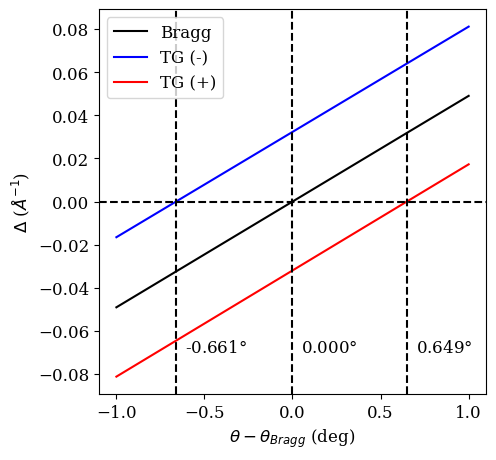

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=1)
cmap = colormaps['summer']

fig.set_figheight(5)
fig.set_figwidth(5)

ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff, c='k', label="Bragg")
ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff_tg, c='b', label='TG (-)')
ax.plot(np.rad2deg(angle_list - bragg_angle), kout_len_diff_tg1, c='r', label='TG (+)')
ax.axhline(y=0, linestyle='--', c='k')
ax.axvline(x=np.rad2deg(bragg_angle - bragg_angle), linestyle='--', c='k')
ax.axvline(x=np.rad2deg(tg_angle - bragg_angle), linestyle='--', c='k')
ax.axvline(x=np.rad2deg(tg1_angle - bragg_angle), linestyle='--', c='k')
ax.text(x=np.rad2deg(bragg_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(bragg_angle - bragg_angle)), )
ax.text(x=np.rad2deg(tg_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(tg_angle - bragg_angle)), )
ax.text(x=np.rad2deg(tg1_angle - bragg_angle) + 0.05,
        y=-0.07,
        s='{:.3f}$\degree$'.format(np.rad2deg(tg1_angle - bragg_angle)), )

ax.set_ylabel("$\Delta$ ($\AA^{-1}$)")
ax.set_xlabel(r'$\theta - \theta_{Bragg}$ (deg)')
plt.legend()
plt.savefig("./phase_matching_calculation.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate the q vector

In [20]:
# When perfectly matching the phase matching condition, we know that 
q_c_vec = np.copy(tVec)

# Get the reciprocal lattice at tg -
g_tg_m = gVec_list[tg_idx]
g_tg_p = gVec_list[tg1_idx]

# Scan the angle and get the q vector at each angle
angle_num = 1000
tg_m_angle_list = np.linspace(start=tg_angle - np.deg2rad(0.05), stop=tg_angle + np.deg2rad(0.05), num=angle_num)
tg_p_angle_list = np.linspace(start=tg1_angle - np.deg2rad(0.05), stop=tg1_angle + np.deg2rad(0.05), num=angle_num)

# Create a holder for the Q for each scan
q_tg_m = np.zeros((angle_num, 3)) + q_c_vec[np.newaxis, :] - g_tg_m[np.newaxis, :]
q_tg_p = np.zeros((angle_num, 3)) - q_c_vec[np.newaxis, :] - g_tg_p[np.newaxis, :]

# Loop through the angles 
for idx in range(angle_num):
    angle_rot = tg_m_angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)], ])

    q_tg_m[idx, :] += np.dot(tilt_mat, np.dot(rot_mat, gVec))

    angle_rot = tg_p_angle_list[idx]
    rot_mat = np.array([[1, 0, 0],
                        [0, np.cos(angle_rot), -np.sin(angle_rot)],
                        [0, np.sin(angle_rot), np.cos(angle_rot)], ])

    q_tg_p[idx, :] += np.dot(tilt_mat, np.dot(rot_mat, gVec))

In [21]:
kout_tg[tg_idx]

array([3.04983703, 1.23892362, 3.71866306])

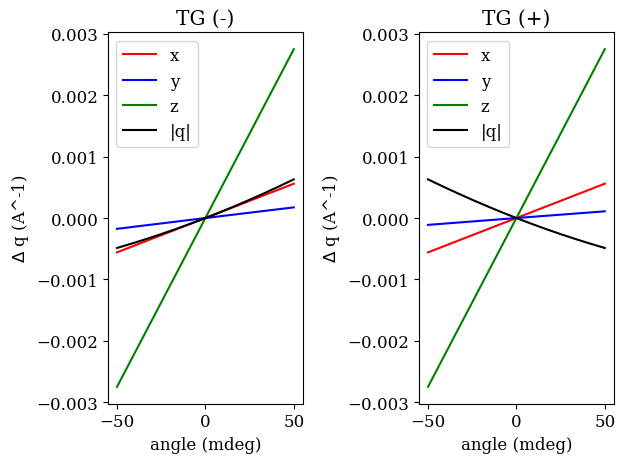

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=1)

axes[0].plot(np.rad2deg(tg_m_angle_list - tg_angle) * 1e3, q_tg_m[:, 0] - q_c_vec[0], c='r', label='x')
axes[0].plot(np.rad2deg(tg_m_angle_list - tg_angle) * 1e3, q_tg_m[:, 1] - q_c_vec[1], c='b', label='y')
axes[0].plot(np.rad2deg(tg_m_angle_list - tg_angle) * 1e3, q_tg_m[:, 2] - q_c_vec[2], c='g', label='z')
axes[0].plot(np.rad2deg(tg_m_angle_list - tg_angle) * 1e3, np.linalg.norm(q_tg_m, axis=-1) - np.linalg.norm(q_c_vec),
             c='k', label='|q|')

axes[0].set_title("TG (-)")
axes[0].set_xlabel("angle (mdeg)")
axes[0].set_ylabel("$\Delta$ q (A^-1)")
axes[0].legend()

axes[1].plot(np.rad2deg(tg_p_angle_list - tg1_angle) * 1e3, q_tg_p[:, 0] + q_c_vec[0], c='r', label='x')
axes[1].plot(np.rad2deg(tg_p_angle_list - tg1_angle) * 1e3, q_tg_p[:, 1] + q_c_vec[1], c='b', label='y')
axes[1].plot(np.rad2deg(tg_p_angle_list - tg1_angle) * 1e3, q_tg_p[:, 2] + q_c_vec[2], c='g', label='z')
axes[1].plot(np.rad2deg(tg_p_angle_list - tg1_angle) * 1e3, np.linalg.norm(q_tg_p, axis=-1) - np.linalg.norm(q_c_vec),
             c='k', label='|q|')
axes[1].set_title("TG (+)")
axes[1].set_xlabel("angle (mdeg)")
axes[1].set_ylabel("$\Delta$ q (A^-1)")
axes[1].legend()

plt.tight_layout()
plt.show()

# Get the minus

In [23]:
# Consider the following fitting process
# According to this calculated q line, we can derive the dependence of delta qy and qz as a function of delta qx.
# In the simulation of the shape factor, we can then get the line 
fit_x = np.polyfit(x=tg_m_angle_list - tg_angle, y=q_tg_m[:, 0] - q_c_vec[0], deg=1)
fit_qx = (tg_m_angle_list - tg_angle) * fit_x[0] + fit_x[1]
print("fit x", fit_x)
fit_y = np.polyfit(x=tg_m_angle_list - tg_angle, y=q_tg_m[:, 1] - q_c_vec[1], deg=1)
fit_qy = (tg_m_angle_list - tg_angle) * fit_y[0] + fit_y[1] 
print("fit y", fit_y)
fit_z = np.polyfit(x=tg_m_angle_list - tg_angle, y=q_tg_m[:, 2] - q_c_vec[2], deg=1)
fit_qz = (tg_m_angle_list - tg_angle) * fit_z[0] + fit_z[1]
print("fit z", fit_z)

fit x [6.40342603e-01 5.06962809e-09]
fit y [ 1.99944147e-01 -4.08478486e-07]
fit z [3.14738445e+00 2.49180183e-08]


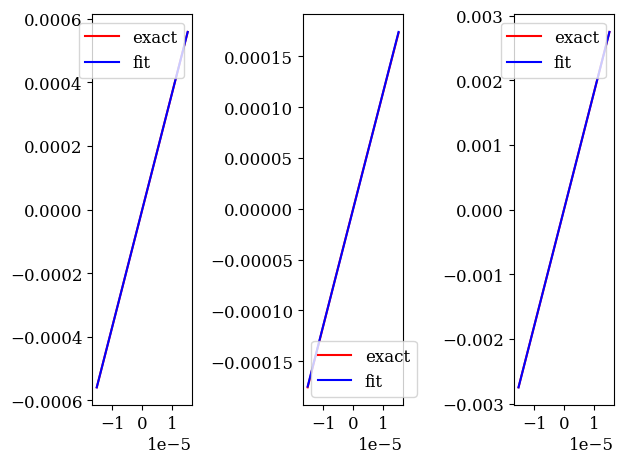

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=1)

axes[0].plot(np.deg2rad(tg_m_angle_list - tg_angle), q_tg_m[:, 0] - q_c_vec[0], c='r', label='exact')
axes[0].plot(np.deg2rad(tg_m_angle_list - tg_angle), fit_qx, c='b', label='fit')
axes[0].legend()

axes[1].plot(np.deg2rad(tg_m_angle_list - tg_angle), q_tg_m[:, 1] - q_c_vec[1], c='r', label='exact')
axes[1].plot(np.deg2rad(tg_m_angle_list - tg_angle), fit_qy, c='b', label='fit')
axes[1].legend()

axes[2].plot(np.deg2rad(tg_m_angle_list - tg_angle), q_tg_m[:, 2] - q_c_vec[2], c='r', label='exact')
axes[2].plot(np.deg2rad(tg_m_angle_list - tg_angle), fit_qz, c='b', label='fit')
axes[2].legend()

plt.tight_layout()
plt.show()

# Get the plus

In [27]:
# Consider the following fitting process
# According to this calculated q line, we can derive the dependence of delta qy and qz as a function of delta qx.
# In the simulation of the shape factor, we can then get the line 
angle_fit = tg_p_angle_list
angle_center = tg1_angle

q_fit = q_tg_p

fit_x = np.polyfit(x=angle_fit - angle_center, y=q_fit[:, 0] + q_c_vec[0], deg=1)
fit_qx = (angle_fit - angle_center) * fit_x[0] + fit_x[1]
print("fit x", fit_x)
fit_y = np.polyfit(x=angle_fit - angle_center, y=q_fit[:, 1] + q_c_vec[1], deg=1)
fit_qy = (angle_fit - angle_center) * fit_y[0] + fit_y[1] 
print("fit y", fit_y)
fit_z = np.polyfit(x=angle_fit - angle_center, y=q_fit[:, 2] + q_c_vec[2], deg=1)
fit_qz = (angle_fit - angle_center) * fit_z[0] + fit_z[1]
print("fit z", fit_z)

fit x [6.41086802e-01 3.20573762e-09]
fit y [ 1.26433034e-01 -4.08953214e-07]
fit z [3.15104230e+00 1.57567036e-08]


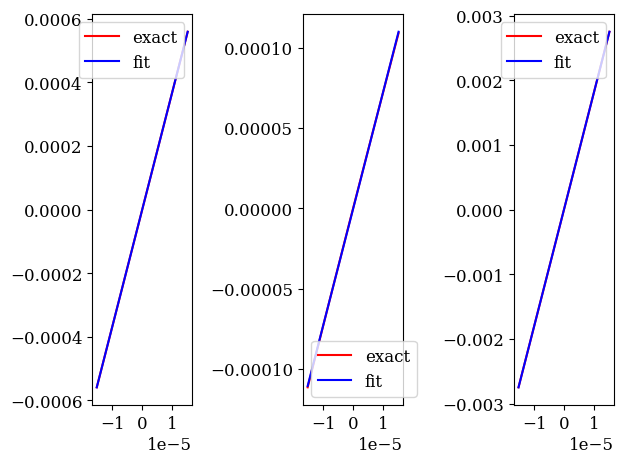

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=1)

axes[0].plot(np.deg2rad(angle_fit - angle_center), q_fit[:, 0] + q_c_vec[0], c='r', label='exact')
axes[0].plot(np.deg2rad(angle_fit - angle_center), fit_qx, c='b', label='fit')
axes[0].legend()

axes[1].plot(np.deg2rad(angle_fit - angle_center), q_fit[:, 1] + q_c_vec[1], c='r', label='exact')
axes[1].plot(np.deg2rad(angle_fit - angle_center), fit_qy, c='b', label='fit')
axes[1].legend()

axes[2].plot(np.deg2rad(angle_fit - angle_center), q_fit[:, 2] + q_c_vec[2], c='r', label='exact')
axes[2].plot(np.deg2rad(angle_fit - angle_center), fit_qz, c='b', label='fit')
axes[2].legend()

plt.tight_layout()
plt.show()